# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [42]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [3]:
# model = models.densenet121(pretrained=True)
# model

C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Toshiba/.torch\models\densenet121-a639ec97.pth
100%|██████████████████████████████████████████████████████████████████| 32342954/32342954 [00:54<00:00, 590487.77it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [11]:
# Freeze parameters so we don't backprop through them
"""
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
"""

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [32]:
torch.cuda.is_available()

True

In [33]:
#model.cuda()

In [34]:
#My_model = model.to('cuda')


In [43]:
import time

In [9]:
"""
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")
"""

Device = cpu; Time per batch: 10.933 seconds
Device = cuda; Time per batch: 0.019 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [44]:
## TODO: Use a pretrained model to classify the cat and dog images

#chech GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 
model = models.resnet50(pretrained = True)

In [45]:
# GPU or not 
print(device)

cuda


In [46]:
# turn off gradient
for para in model.parameters():
    para.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(2048,512),
                          nn.ReLU(),
                           nn.Dropout(p=0.2),
                          nn.Linear(512,2),
                          nn.LogSoftmax(dim = 1))

model.fc = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [47]:
epochs = 2
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for image, label in trainloader:
        steps +=1
        
        start = time.time()
        
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        logps = model(image)
        loss = criterion(logps, label)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            
            for image, label in testloader:
                image, label = image.to(device), label.to(device)
                
                logps = model(image)
                loss = criterion(logps, label)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == label.view(*top_class.shape)
                
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            running_loss = 0
            model.train()
            
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")


Epoch 1/2.. Train loss: 1.667.. Test loss: 0.081.. Test accuracy: 0.973
Epoch 1/2.. Train loss: 0.914.. Test loss: 0.379.. Test accuracy: 0.897
Epoch 1/2.. Train loss: 0.694.. Test loss: 0.268.. Test accuracy: 0.910
Epoch 1/2.. Train loss: 0.316.. Test loss: 0.085.. Test accuracy: 0.967
Epoch 1/2.. Train loss: 0.388.. Test loss: 0.068.. Test accuracy: 0.975
Epoch 1/2.. Train loss: 0.189.. Test loss: 0.070.. Test accuracy: 0.972
Epoch 1/2.. Train loss: 0.146.. Test loss: 0.121.. Test accuracy: 0.954
Epoch 1/2.. Train loss: 0.198.. Test loss: 0.068.. Test accuracy: 0.974
Epoch 1/2.. Train loss: 0.249.. Test loss: 0.060.. Test accuracy: 0.977
Epoch 1/2.. Train loss: 0.163.. Test loss: 0.095.. Test accuracy: 0.961
Epoch 1/2.. Train loss: 0.186.. Test loss: 0.058.. Test accuracy: 0.979
Epoch 1/2.. Train loss: 0.193.. Test loss: 0.057.. Test accuracy: 0.980
Epoch 1/2.. Train loss: 0.122.. Test loss: 0.078.. Test accuracy: 0.968
Epoch 1/2.. Train loss: 0.181.. Test loss: 0.057.. Test accuracy

Epoch 2/2.. Train loss: 0.140.. Test loss: 0.062.. Test accuracy: 0.979
Epoch 2/2.. Train loss: 0.124.. Test loss: 0.049.. Test accuracy: 0.978
Epoch 2/2.. Train loss: 0.156.. Test loss: 0.040.. Test accuracy: 0.985
Epoch 2/2.. Train loss: 0.152.. Test loss: 0.049.. Test accuracy: 0.982
Epoch 2/2.. Train loss: 0.178.. Test loss: 0.062.. Test accuracy: 0.973
Epoch 2/2.. Train loss: 0.133.. Test loss: 0.038.. Test accuracy: 0.987
Epoch 2/2.. Train loss: 0.108.. Test loss: 0.037.. Test accuracy: 0.988
Epoch 2/2.. Train loss: 0.194.. Test loss: 0.037.. Test accuracy: 0.987
Epoch 2/2.. Train loss: 0.151.. Test loss: 0.040.. Test accuracy: 0.984
Epoch 2/2.. Train loss: 0.134.. Test loss: 0.057.. Test accuracy: 0.977
Epoch 2/2.. Train loss: 0.130.. Test loss: 0.052.. Test accuracy: 0.980
Epoch 2/2.. Train loss: 0.200.. Test loss: 0.054.. Test accuracy: 0.979
Epoch 2/2.. Train loss: 0.091.. Test loss: 0.042.. Test accuracy: 0.985
Epoch 2/2.. Train loss: 0.167.. Test loss: 0.043.. Test accuracy

## try another nn architecture

In [7]:
data_dir = 'Cat_Dog_data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import time
nmodel = models.densenet121(pretrained = True)

C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [9]:
nmodel

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [12]:
for para in nmodel.parameters():
    para.requires_grad = False
    
classifier_ud = nn.Sequential(nn.Linear(1024,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                          nn.Linear(128,2),
                          nn.LogSoftmax(dim = 1)
                          )

nmodel.classifier = classifier_ud

criterion = nn.NLLLoss()

optimizer = optim.SGD(nmodel.classifier.parameters(), lr=0.001)

nmodel.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [13]:
epochs = 1
steps = 0

print_every = 20

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    
    for image, label in trainloader:
        steps +=1
        
        start = time.time()
        
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        logps = nmodel(image)
        loss = criterion(logps, label)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(steps)
            
            nmodel.eval()
            test_loss = 0
            accuracy = 0
            
            for image, label in testloader:
                image, label = image.to(device), label.to(device)
                
                logps = nmodel(image)
                loss = criterion(logps, label)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == label.view(*top_class.shape)
                
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            #running_loss = 0
            nmodel.train()
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader)) 
            
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

20
Epoch 1/1.. Train loss: 0.683.. Test loss: 0.662.. Test accuracy: 0.579
40
Epoch 1/1.. Train loss: 1.334.. Test loss: 0.634.. Test accuracy: 0.704
60
Epoch 1/1.. Train loss: 1.972.. Test loss: 0.609.. Test accuracy: 0.807
80
Epoch 1/1.. Train loss: 2.587.. Test loss: 0.584.. Test accuracy: 0.893
100
Epoch 1/1.. Train loss: 3.180.. Test loss: 0.562.. Test accuracy: 0.914
120
Epoch 1/1.. Train loss: 3.764.. Test loss: 0.539.. Test accuracy: 0.931
140
Epoch 1/1.. Train loss: 4.326.. Test loss: 0.517.. Test accuracy: 0.940
160
Epoch 1/1.. Train loss: 4.868.. Test loss: 0.496.. Test accuracy: 0.949
180
Epoch 1/1.. Train loss: 5.400.. Test loss: 0.476.. Test accuracy: 0.955
200
Epoch 1/1.. Train loss: 5.919.. Test loss: 0.457.. Test accuracy: 0.959
220
Epoch 1/1.. Train loss: 6.425.. Test loss: 0.438.. Test accuracy: 0.961
240
Epoch 1/1.. Train loss: 6.909.. Test loss: 0.417.. Test accuracy: 0.962
260
Epoch 1/1.. Train loss: 7.375.. Test loss: 0.402.. Test accuracy: 0.960
280
Epoch 1/1.. 

In [20]:
train_n_loss = []
for i in range(len(train_losses)-1):
    train_n_loss.append(train_losses[i+1] - train_losses[i])

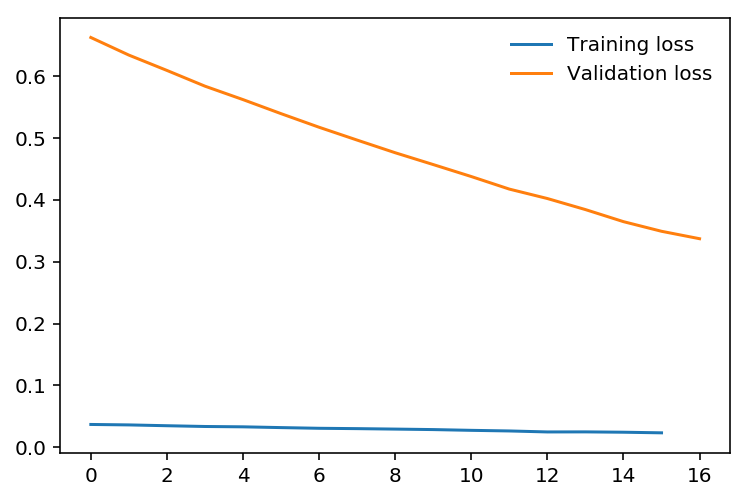

In [22]:
plt.plot(train_n_loss, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)